This notebook provides a tutorial for the code used in the paper "Latent circuit inference from heterogeneous neural responses during cognitive tasks", Langdon and Engel 2022. It demonstrates how we trained an RNN on a context-dependent decision-making task and fit a latent circuit model to its responses. 

In [40]:
from net import *
from latent_net import *
from plotting_functions import *

## Train RNN on context-dependent decision-making task

#### Generate inputs (u) and targets (z) for the context-dependent decision-making task used in Siegel et al. Also generate a mask that restricts where in the trial errors are penalized.

In [65]:
from Tasks.SiegelMillerTask import *
u, z, mask, conditions  = generate_trials( n_trials=25,
                                                alpha=float(0.2),
                                                sigma_in=0.01,
                                                baseline=.2,
                                                n_coh=6)

#### Initialize and fit RNN model with 50 units and Dales Law constraint.

In [66]:
net = Net(n=50, input_size=6, dale=True, sigma_rec=0.15 )
net.fit(u, z, mask, lr=.01,
        epochs=150, 
        verbose=True, 
        weight_decay=0.001)
# Note: Due to random initialization of network parameters, not every run will result in a successful network.

Epoch: 5/150............. mse_z: 0.0417
Epoch: 10/150............. mse_z: 0.0396
Epoch: 15/150............. mse_z: 0.0396
Epoch: 20/150............. mse_z: 0.0397
Epoch: 25/150............. mse_z: 0.0386
Epoch: 30/150............. mse_z: 0.0317
Epoch: 35/150............. mse_z: 0.0115
Epoch: 40/150............. mse_z: 0.0091
Epoch: 45/150............. mse_z: 0.0117
Epoch: 50/150............. mse_z: 0.0082
Epoch: 55/150............. mse_z: 0.0139
Epoch: 60/150............. mse_z: 0.0113
Epoch: 65/150............. mse_z: 0.0093
Epoch: 70/150............. mse_z: 0.0102
Epoch: 75/150............. mse_z: 0.0149
Epoch: 80/150............. mse_z: 0.0072
Epoch: 85/150............. mse_z: 0.0078
Epoch: 90/150............. mse_z: 0.0127
Epoch: 95/150............. mse_z: 0.0160
Epoch: 100/150............. mse_z: 0.0080
Epoch: 105/150............. mse_z: 0.0120
Epoch: 110/150............. mse_z: 0.0088
Epoch: 115/150............. mse_z: 0.0095
Epoch: 120/150............. mse_z: 0.0077
Epoch: 125/1

#### Visualize connectivity parameters of RNN after training

<AxesSubplot:>

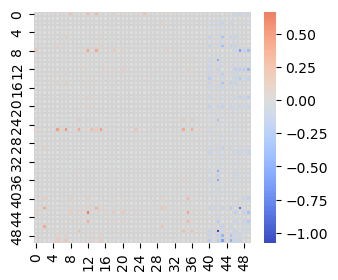

In [67]:
plt.figure(figsize=(3.5,3))
sns.heatmap( net.recurrent_layer.weight.data.detach().numpy(),center=0,cmap='coolwarm',linewidths=.1,linecolor='lightgray')

#### Plot psychometric functions for trained RNN

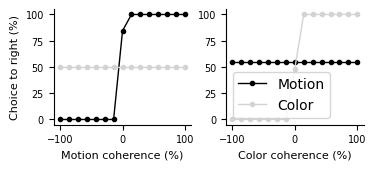

In [68]:

u, _, _, conditions  = generate_trials( n_trials=25,
                                                alpha=float(0.2),
                                                sigma_in=0.01,
                                                baseline=.2,
                                                n_coh=15)
df = psychometric(net,u,conditions)

## Fit latent circuit model to trained RNN

#### Initialize and fit latent circuit model

In [69]:
# Initialize
latent_net = LatentNet(n=8, N=net.n ,input_size=6, n_trials = u.shape[0],sigma_rec = 0.15)

# Generate inputs to simulate RNN
u, _, _, _  = generate_trials( n_trials=25,
                                                alpha=float(0.2),
                                                sigma_in=0.01,
                                                baseline=.2,
                                                n_coh=6)
# Simulate RNN
y = net(u)
z = net.output_layer(y)
# Fit latent circuit model
loss_history = latent_net.fit(u.detach(),z.detach(),y.detach(),epochs = 500,lr = .02,l_y = 1,weight_decay = 0.001)

Epoch: 0/500............. mse_z: 0.4166 nmse_y: 0.7505
Epoch: 10/500............. mse_z: 0.1184 nmse_y: 0.3038
Epoch: 20/500............. mse_z: 0.0481 nmse_y: 0.1222
Epoch: 30/500............. mse_z: 0.0292 nmse_y: 0.0854
Epoch: 40/500............. mse_z: 0.0312 nmse_y: 0.0866
Epoch: 50/500............. mse_z: 0.0346 nmse_y: 0.0983
Epoch: 60/500............. mse_z: 0.0256 nmse_y: 0.0763
Epoch: 70/500............. mse_z: 0.0253 nmse_y: 0.0799
Epoch: 80/500............. mse_z: 0.0266 nmse_y: 0.0801
Epoch: 90/500............. mse_z: 0.0238 nmse_y: 0.0708
Epoch: 100/500............. mse_z: 0.0243 nmse_y: 0.0758
Epoch: 110/500............. mse_z: 0.0249 nmse_y: 0.0827
Epoch: 120/500............. mse_z: 0.0258 nmse_y: 0.0784
Epoch: 130/500............. mse_z: 0.0242 nmse_y: 0.0760
Epoch: 140/500............. mse_z: 0.0235 nmse_y: 0.0740
Epoch: 150/500............. mse_z: 0.0281 nmse_y: 0.0867
Epoch: 160/500............. mse_z: 0.0246 nmse_y: 0.0721
Epoch: 170/500............. mse_z: 0.0238 

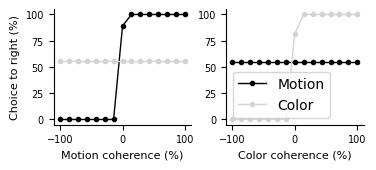

In [70]:
# Plot psychometric functions
u, z, mask, conditions  = generate_trials( n_trials=25,
                                                alpha=float(0.2),
                                                sigma_in=0.01,
                                                baseline=.2,
                                                n_coh=15)
df = psychometric(latent_net,u,conditions)

<AxesSubplot:>

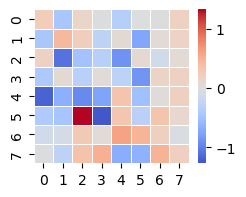

In [71]:
plt.figure(figsize=(2.5,2))
w_rec  = latent_net.recurrent_layer.weight.data.detach()
sns.heatmap(w_rec,center=0,cmap='coolwarm',linewidths=.5)

## Assessing fit quality of latent circuit model
There are several ways to assess the quality of fit of the latent circuit model.
1) Agreement between $Qx$ and $y$ where $x$ is the responses of the latent model, $y$ is the responses of the RNN and $Q$ is the orthonormal matrix that maps $x$ onto $y$.
2) Agreement between $x$ and $Q^Ty$ i.e. agreement in the subspace spanned by the columns of $Q$.
3) Agreement between $w_{rec}$ and $Q^TW_{rec}$.

#### 1) Agreement between $Qx$ and $y$

(-0.25909741669893266, 1.3743324771523475)

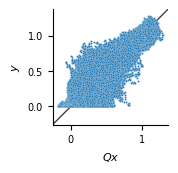

In [72]:
u, _, _, _  = generate_trials( n_trials=25,
                                                alpha=float(0.2),
                                                sigma_in=0.01,
                                                baseline=.2,
                                                n_coh=6)
y  = net(u).detach()
qx = latent_net(u)@latent_net.q
fig = plt.figure(figsize=(1.5,1.5))
gs = gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs[0,0])
sns.scatterplot(x =qx.detach().flatten(),y = y.flatten(),ax=ax,s=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("", fontsize=8)
ax.xaxis.set_tick_params(labelsize=7,bottom=True)
ax.yaxis.set_tick_params(labelsize=7,left=True)
ax.set_xlabel(r"$Qx$", fontsize=8)
ax.set_ylabel(r"$y$", fontsize=8)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0,lw=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

#### 2) Agreement between $x$ and $Q^Ty$

(-0.18462084904313086, 1.8595227420330047)

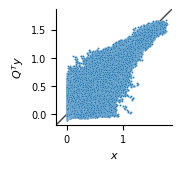

In [73]:
u, _, _, _  = generate_trials( n_trials=25,
                                                alpha=float(0.2),
                                                sigma_in=0.01,
                                                baseline=.2,
                                                n_coh=6)
qty  = net(u).detach()@latent_net.q.t()
x = latent_net(u)
fig = plt.figure(figsize=(1.5,1.5))
gs = gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs[0,0])
sns.scatterplot(x =x.detach().flatten(),y = qty.detach().flatten(),ax=ax,s=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("", fontsize=8)
ax.xaxis.set_tick_params(labelsize=7,bottom=True)
ax.yaxis.set_tick_params(labelsize=7,left=True)
ax.set_xlabel(r"$x$", fontsize=8)
ax.set_ylabel(r"$Q^Ty$", fontsize=8)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0,lw=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

#### 3) Agreement between $w_{rec}$ and $Q^TW_{rec}Q$

Text(0.5, 1.0, '$Q^Tw_{rec}Q$')

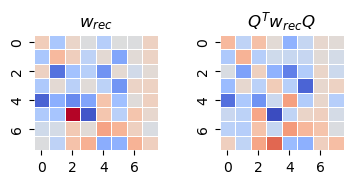

In [74]:
w_rec = latent_net.recurrent_layer.weight.data.detach()
q = latent_net.q.detach()
W_rec = net.recurrent_layer.weight.data.detach()

# Plot
fig = plt.figure(figsize=(4,1.5))
gs = gridspec.GridSpec(1,2,wspace = .5)
ax0=fig.add_subplot(gs[0,0])
ax1=fig.add_subplot(gs[0,1])

sns.heatmap(w_rec, ax=ax0, cmap='coolwarm',center=0,cbar=False,lw=.5)
ax0.set_title(r"$w_{rec}$")
sns.heatmap(q@W_rec@q.T, ax=ax1, cmap='coolwarm',center=0,cbar=False,lw=.5)
ax1.set_title(r"$Q^Tw_{rec}Q$")